<a href="https://colab.research.google.com/github/tribber93/ML-Capstone-Project/blob/main/Sistem_Rekomendasi_Content_Based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#membaca dataset
path = '/content/drive/MyDrive/dataset/Dataset - Capstone Project - Data Kuesioner (2).csv'
df = pd.read_csv(path)
df = df.drop(columns=['jumlah rating', 'link'])
df.head(14)

,kuesioner_id,judul,deskripsi,rentang usia,kategori,rata-rata rating
0,1,Pengaruh Persepsi Risiko Terhadap Keputusan Pe...,Saya Dewi Sri Sulastri mahasiswa semester 8 Sa...,umum,online shop,4.0
1,2,"Pola Asuh, Dukungan Sosial, dan Self-esteem.","Selamat datang, terima kasih sudah meluangkan ...","18-25, 26-35, 36-45",Sosial,4.5
2,3,"Kuesioner Penelitian ""Pengaruh Persepsi Kemuda...","Dengan ini, memohon kesediaan Bapak/Ibu/Saudar...",umum,"ekonomi, teknologi",3.9
3,4,"PENGARUH KOREAN WAVE, BRAND AMBASSADOR, DAN SH...",Binusian 2023 Jurusan Business Management. Saa...,umum,hobi/hiburan,4.0
4,5,Pengaruh Ulasan Online pada platform TikTok te...,Assalamualaikum Wr. Wb.\n\nYth. Responden di T...,umum,"online shop, kecantikan, sosial media",4.2
5,6,Anteseden Financial Management Behavior Dari K...,Selamat pagi/siang/malam.\r\nPerkenalkan saya ...,"18-25, 26-35",hobi/hiburan,3.5
6,7,"PENGARUH KUALITAS PRODUK, HARGA TERHADAP KEPUT...","Bersama ini, saya Debora Meilani Sitompul maha...",umum,konsumen,4.0
7,8,Kuesioner Penelitian: Analisis keputusan perpi...,"Kepada responden yang terhormat, perkenalkan k...",umum,mahasiswa,4.0
8,9,Kuesioner Penelitian Kuliner Khas Betawi,Kuesioner berikut akan menjadi bahan penelitia...,umum,makanan,3.7
9,10,"Skala Uji Coba Skripsi ""Hubungan Parasocial Re...","Halo, perkenalkan saya Siti Rafa Amira Hakam m...",18-25,hobi/hiburan,4.5


In [4]:
df.describe()

,kuesioner_id,rata-rata rating
count,194.000000,194.000000
mean,97.500000,3.910309
std,56.147128,0.414500
min,1.000000,3.000000
25%,49.250000,3.700000
50%,97.500000,4.000000
75%,145.750000,4.200000
max,194.000000,4.500000


In [5]:
#fungsi membuat teks menjadi lowercase
def toLowercase(df):
  return [str(lower).lower() for lower in df]
#fungsi membuat teks menjadi list
def toList(df):
    return [i.split(', ') for i in df]

In [6]:

features = [ 'judul', 'deskripsi', 'rentang usia','kategori']
for feature in features:
  df[feature] = toLowercase(df[feature])

In [7]:
try:
  df['rentang usia']=toList(df['rentang usia'])
  df['kategori']=toList(df['kategori'])
except:
  print('Sudah diubah')
df.head()

,kuesioner_id,judul,deskripsi,rentang usia,kategori,rata-rata rating
0,1,pengaruh persepsi risiko terhadap keputusan pe...,saya dewi sri sulastri mahasiswa semester 8 sa...,[umum],[online shop],4.0
1,2,"pola asuh, dukungan sosial, dan self-esteem.","selamat datang, terima kasih sudah meluangkan ...","[18-25, 26-35, 36-45]",[sosial],4.5
2,3,"kuesioner penelitian ""pengaruh persepsi kemuda...","dengan ini, memohon kesediaan bapak/ibu/saudar...",[umum],"[ekonomi, teknologi]",3.9
3,4,"pengaruh korean wave, brand ambassador, dan sh...",binusian 2023 jurusan business management. saa...,[umum],[hobi/hiburan],4.0
4,5,pengaruh ulasan online pada platform tiktok te...,assalamualaikum wr. wb.\n\nyth. responden di t...,[umum],"[online shop, kecantikan, sosial media]",4.2


In [8]:
df['kategori'][35]

['hobi/hiburan', 'teknologi']

In [9]:
import itertools
list_kategori = df['kategori']
list_kategori = list(itertools.chain(*list_kategori))

from collections import Counter
df_kategori_count = pd.DataFrame(Counter(list_kategori).most_common(), columns=['kategori', 'Jumlah'])
df_kategori_count

,kategori,Jumlah
0,perilaku,36
1,ekonomi,32
2,bisnis,31
3,teknologi,25
4,sosial media,18
5,sosial,15
6,hobi/hiburan,15
7,marketing,14
8,pendidikan,13
9,kesehatan,12


In [10]:
get_col = pd.DataFrame(columns=df_kategori_count['kategori'].values)
get_col.to_csv('output.csv')

In [11]:
import itertools
list_usia = df['rentang usia']
list_usia = list(itertools.chain(*list_usia))

from collections import Counter
df_usia_count = pd.DataFrame(Counter(list_usia).most_common(), columns=['rentang usia', 'Jumlah'])
df_usia_count

,rentang usia,Jumlah
0,umum,139
1,18-25,47
2,26-35,15
3,15-17,11
4,36-45,6
5,46-55,2


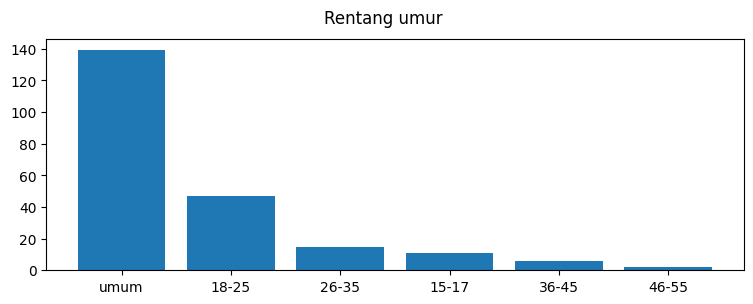

In [12]:
plt.figure(figsize=(9, 3))

# plt.subplot()
plt.bar(df_usia_count['rentang usia'], df_usia_count['Jumlah'])
plt.suptitle('Rentang umur')
plt.show()

In [13]:
encode = preprocessing.LabelEncoder()

In [14]:
# encode_kategori = encode.fit_transform(df_kategori_count['kategori'])
# encode_kategori.shape
# encode_usia = encode.fit_transform(df_usia_count['rentang usia'])
# pd.DataFrame({'usia':df_usia_count['rentang usia'],'encode_usia':encode_usia})
# encode_usia

In [15]:
jenis_kategori = df_kategori_count['kategori'].values.tolist()
num_categories = len(jenis_kategori)

def encode_category(category):
    # Membuat vektor nol dengan panjang yang sama dengan jumlah kategori
    encoded_category = [0] * num_categories

    for i in category:
      # Menentukan indeks kategori yang sesuai
      category_index = jenis_kategori.index(i)

      # Mengatur nilai 1 pada indeks kategori yang sesuai
      encoded_category[category_index] = 1


    return encoded_category

encoded = []
for kategori in df['kategori']:
  encoded_category = encode_category(kategori)
  encoded.append(encoded_category)

In [16]:
# pd.DataFrame([i for i in encoded] ,columns=df_kategori_count['kategori'])

In [17]:
df_usia_count['rentang usia']

0     umum
1    18-25
2    26-35
3    15-17
4    36-45
5    46-55
Name: rentang usia, dtype: object

In [18]:
jenis_usia = df_usia_count['rentang usia'].values.tolist()
jumlah_jenis_usia = len(jenis_usia)

def encode_usia(usia,user = False):
    # Membuat vektor nol dengan panjang yang sama dengan jumlah usia
    encoded_usia = [0] * jumlah_jenis_usia

    for i in usia:
      # Menentukan indeks usia yang sesuai
      usia_index = jenis_usia.index(i)

      # Mengatur nilai 1 pada indeks usia yang sesuai
      encoded_usia[usia_index] = 1

    if user:
      encoded_usia[0] = 1

    return encoded_usia

usia_encoded = []
for usia in df['rentang usia']:
  encoded1 = encode_usia(usia)
  usia_encoded.append(encoded1)

In [19]:
df_temp = pd.DataFrame(columns=df_usia_count['rentang usia'].values)
df_kategori = pd.DataFrame(columns=df_kategori_count['kategori'].values)
df_temp = df_temp.merge(df_kategori, left_index=True, right_index= True)

In [20]:
usia_array = np.array(usia_encoded)
kategori_array = np.array(encoded)
for idx, x in enumerate(df_usia_count['rentang usia']):
  df_temp[x] = usia_array[:,idx]
for idx2, x2 in enumerate(df_kategori_count['kategori']):
  df_temp[x2] = kategori_array[:,idx2]

In [21]:
item_train = df_temp
item_train.insert(1, "rata-rata rating", df['rata-rata rating'], True)
item_train

,umum,rata-rata rating,18-25,26-35,15-17,36-45,46-55,perilaku,ekonomi,bisnis,...,pariwisata,pelayanan,online shop,budaya,konsumen,percintaan,mahasiswa,makanan,kecantikan,politik/pemerintahan
0,1,4.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,4.5,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,3.9,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,4.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4.2,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,1,4.2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
190,0,3.7,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
191,0,4.3,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
192,0,4.1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [22]:
id_kuesioner = df['kuesioner_id'].values
item_vecs = df_temp
item_vecs.insert(0, "kuesioner_id", id_kuesioner, True)
# item_vecs.head()

In [23]:
df_user = pd.read_csv('/content/drive/MyDrive/dataset/output user1.csv')
df_user.head()

,user_id,pekerjaan,usia,rata-rata rating,perilaku,ekonomi,bisnis,teknologi,sosial media,sosial,...,pariwisata,pelayanan,online shop,budaya,konsumen,percintaan,mahasiswa,makanan,kecantikan,politik/pemerintahan
0,3,wiraswasta,30,3.2,0,4,4,3,3,0,...,3,2,3,0,3,3,0,4,3,0
1,3,wiraswasta,30,3.2,0,4,4,3,3,0,...,3,2,3,0,3,3,0,4,3,0
2,3,wiraswasta,30,3.2,0,4,4,3,3,0,...,3,2,3,0,3,3,0,4,3,0
3,3,wiraswasta,30,3.2,0,4,4,3,3,0,...,3,2,3,0,3,3,0,4,3,0
4,3,wiraswasta,30,3.2,0,4,4,3,3,0,...,3,2,3,0,3,3,0,4,3,0


In [24]:
try:
  for i in range(len(df_user['usia'])):
    if df_user['usia'][i] >= 15 and df_user['usia'][i] < 18:
      df_user['usia'][i] = ['18-25']
    elif df_user['usia'][i] >= 18 and df_user['usia'][i] < 26:
      df_user['usia'][i] = ['18-25']
    elif df_user['usia'][i] >= 26 and df_user['usia'][i] < 36:
      df_user['usia'][i] = ['26-35']
    elif df_user['usia'][i] >= 36 and df_user['usia'][i] < 46:
      df_user['usia'][i] = ['36-45']
    elif df_user['usia'][i] >= 46 and df_user['usia'][i] < 56:
      df_user['usia'][i] = ['46-55']
    else:
      df_user['usia'][i] = ['umum']
except:
  print('sudah diubah')

<ipython-input-24-6d1a2328323b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user['usia'][i] = ['26-35']


In [25]:
usia = []
for i in df_user['usia']:
  usia.append(encode_usia(i,user=True))

In [26]:
df_usia_user = pd.DataFrame(columns=df_usia_count['rentang usia'].values)
usia = np.array(usia)
# usia
for idx3, x3 in enumerate(df_usia_count['rentang usia']):
  df_usia_user[x3] = usia[:,idx3]

In [27]:
df_temp_user = df_usia_user.merge(df_user, left_index=True, right_index= True).drop(columns=['user_id','usia'])
user_train = df_temp_user.drop(columns=['rata-rata rating'])
# user_train

In [28]:
list_pekerjaan = df_user['pekerjaan']
list_pekerjaan = list(itertools.chain(list_pekerjaan))

df_pekerjaan_count = pd.DataFrame(Counter(list_pekerjaan).most_common(), columns=['pekerjaan', 'Jumlah'])
df_pekerjaan_count

,pekerjaan,Jumlah
0,mahasiswa,31
1,tenaga pendidikan,29
2,wiraswasta,26
3,aparatur/pejabat negara,24
4,tenaga kesehatan,23
5,pertanian/pertenakan,22
6,tidak bekerja,21
7,agama dan kepercayaan,18


In [29]:
pekerjaan = preprocessing.LabelEncoder()
encode_pekerjaan = pekerjaan.fit_transform(df_user['pekerjaan'])
# pekerjaan.inverse_transform([1])
df_user['pekerjaan'] = encode_pekerjaan

In [30]:
user_train['pekerjaan'] = df_user['pekerjaan']
# user_train

y_train = df_temp_user['rata-rata rating']
y_train
# df_user = df_user.drop(columns=['user_id', 'pekerjaan'])
# df_user.head()


0      3.2
1      3.2
2      3.2
3      3.2
4      3.2
      ... 
189    2.4
190    2.4
191    2.4
192    2.4
193    2.4
Name: rata-rata rating, Length: 194, dtype: float64

In [31]:
user_train

,umum,18-25,26-35,15-17,36-45,46-55,pekerjaan,perilaku,ekonomi,bisnis,...,pariwisata,pelayanan,online shop,budaya,konsumen,percintaan,mahasiswa,makanan,kecantikan,politik/pemerintahan
0,1,0,1,0,0,0,7,0,4,4,...,3,2,3,0,3,3,0,4,3,0
1,1,0,1,0,0,0,7,0,4,4,...,3,2,3,0,3,3,0,4,3,0
2,1,0,1,0,0,0,7,0,4,4,...,3,2,3,0,3,3,0,4,3,0
3,1,0,1,0,0,0,7,0,4,4,...,3,2,3,0,3,3,0,4,3,0
4,1,0,1,0,0,0,7,0,4,4,...,3,2,3,0,3,3,0,4,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,1,0,1,0,0,0,0,5,1,1,...,0,3,2,3,0,1,0,2,0,3
190,1,0,1,0,0,0,0,5,1,1,...,0,3,2,3,0,1,0,2,0,3
191,1,0,1,0,0,0,0,5,1,1,...,0,3,2,3,0,1,0,2,0,3
192,1,0,1,0,0,0,0,5,1,1,...,0,3,2,3,0,1,0,2,0,3


In [32]:
y_train.shape

(194,)

In [33]:
# scale training data
item_train_unscaled = item_train
user_train_unscaled = user_train
y_train_unscaled    = y_train

scalerItem = StandardScaler()
scalerItem.fit(item_train)
item_train = scalerItem.transform(item_train)

scalerUser = StandardScaler()
scalerUser.fit(user_train)
user_train = scalerUser.transform(user_train)

scalerTarget = MinMaxScaler((-1, 1))
scalerTarget.fit(y_train.values.reshape(-1, 1))
y_train = scalerTarget.transform(y_train.values.reshape(-1, 1))
#ynorm_test = scalerTarget.transform(y_test.reshape(-1, 1))

print(np.allclose(item_train_unscaled, scalerItem.inverse_transform(item_train)))
print(np.allclose(user_train_unscaled, scalerUser.inverse_transform(user_train)))

True
True


In [34]:
user_train_unscaled

,umum,18-25,26-35,15-17,36-45,46-55,pekerjaan,perilaku,ekonomi,bisnis,...,pariwisata,pelayanan,online shop,budaya,konsumen,percintaan,mahasiswa,makanan,kecantikan,politik/pemerintahan
0,1,0,1,0,0,0,7,0,4,4,...,3,2,3,0,3,3,0,4,3,0
1,1,0,1,0,0,0,7,0,4,4,...,3,2,3,0,3,3,0,4,3,0
2,1,0,1,0,0,0,7,0,4,4,...,3,2,3,0,3,3,0,4,3,0
3,1,0,1,0,0,0,7,0,4,4,...,3,2,3,0,3,3,0,4,3,0
4,1,0,1,0,0,0,7,0,4,4,...,3,2,3,0,3,3,0,4,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,1,0,1,0,0,0,0,5,1,1,...,0,3,2,3,0,1,0,2,0,3
190,1,0,1,0,0,0,0,5,1,1,...,0,3,2,3,0,1,0,2,0,3
191,1,0,1,0,0,0,0,5,1,1,...,0,3,2,3,0,1,0,2,0,3
192,1,0,1,0,0,0,0,5,1,1,...,0,3,2,3,0,1,0,2,0,3


In [35]:
print(item_train_unscaled.shape)
print(user_train_unscaled.shape)
print(y_train_unscaled.shape)

(194, 28)
(194, 27)
(194,)


In [36]:

item_train, item_test = train_test_split(item_train, train_size=0.80, shuffle=True, random_state=1)
user_train, user_test = train_test_split(user_train, train_size=0.80, shuffle=True, random_state=1)
y_train, y_test       = train_test_split(y_train,    train_size=0.80, shuffle=True, random_state=1)
print(f"movie/item training data shape: {item_train.shape}")
print(f"movie/item test data shape: {item_test.shape}")
print(f"y_train data shape: {y_train.shape}")
print(f"y_test data shape: {y_test.shape}")

movie/item training data shape: (155, 28)
movie/item test data shape: (39, 28)
y_train data shape: (155, 1)
y_test data shape: (39, 1)


In [57]:
num_item_features = item_train.shape[1]
num_user_features = user_train.shape[1]


num_outputs = 32
tf.random.set_seed(1)
user_NN = tf.keras.models.Sequential([
    ### START CODE HERE ###
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='linear'),
    ### END CODE HERE ###
])

item_NN = tf.keras.models.Sequential([
    ### START CODE HERE ###
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='linear'),
    ### END CODE HERE ###
])

# create the user input and point to the base network
input_user = tf.keras.layers.Input(shape=(num_user_features))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

# create the item input and point to the base network
input_item = tf.keras.layers.Input(shape=(num_item_features))
vm = item_NN(input_item)
vm = tf.linalg.l2_normalize(vm, axis=1)

# compute the dot product of the two vectors vu and vm
output = tf.keras.layers.Dot(axes=1)([vu, vm])

# specify the inputs and output of the model
model = tf.keras.Model([input_user, input_item], output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 27)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 28)]         0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 32)           44192       ['input_3[0][0]']                
                                                                                                  
 sequential_3 (Sequential)      (None, 32)           44448       ['input_4[0][0]']                
                                                                                            

In [58]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss=cost_fn,metrics=['accuracy'])

In [59]:
tf.random.set_seed(1)
history = model.fit([user_train, item_train], y_train, epochs=30)

Epoch 1/30
5/5 [==============================] - 2s 9ms/step - loss: 0.1826 - accuracy: 0.0194
Epoch 2/30
5/5 [==============================] - 0s 6ms/step - loss: 0.0412 - accuracy: 0.0774
Epoch 3/30
5/5 [==============================] - 0s 6ms/step - loss: 0.0244 - accuracy: 0.0774
Epoch 4/30
5/5 [==============================] - 0s 7ms/step - loss: 0.0117 - accuracy: 0.0774
Epoch 5/30
5/5 [==============================] - 0s 8ms/step - loss: 0.0091 - accuracy: 0.0774
Epoch 6/30
5/5 [==============================] - 0s 6ms/step - loss: 0.0060 - accuracy: 0.0774
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 0.0026 - accuracy: 0.0774
Epoch 8/30
5/5 [==============================] - 0s 6ms/step - loss: 0.0023 - accuracy: 0.0774
Epoch 9/30
5/5 [==============================] - 0s 7ms/step - loss: 8.6870e-04 - accuracy: 0.0774
Epoch 10/30
5/5 [==============================] - 0s 7ms/step - loss: 0.0011 - accuracy: 0.0774    
Epoch 11/30
5/5 [==============

In [60]:
model.evaluate([user_test, item_test], y_test)

2/2 [==============================] - 0s 11ms/step - loss: 1.1523e-04 - accuracy: 0.2051


[0.00011523399007273838, 0.20512820780277252]

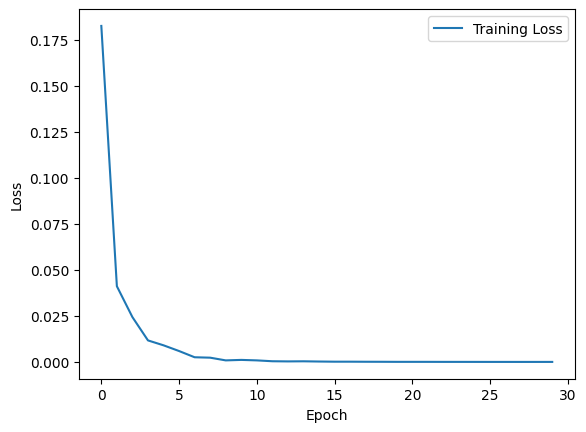

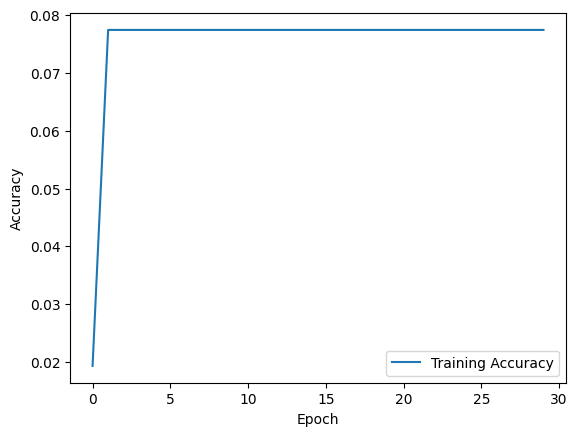

In [61]:
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot grafik akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [62]:
def gen_user_vecs(user_vec, num_items):
    """ given a user vector return:
        user predict maxtrix to match the size of item_vecs """
    user_vecs = np.tile(user_vec, (num_items, 1))
    return user_vecs

def print_pred_movies(y_p, item, movie_dict, maxcount=10):
    """ print results of prediction of a new user. inputs are expected to be in
        sorted order, unscaled. """
    count = 0
    # disp = [["y_p", "kuesioner id", "rata raa rating", "judul", "rentang umur", "kategori"]]
    df_pred = pd.DataFrame(columns=["kuesioner id", "rata rata rating", "judul", "rentang umur", "kategori"])

    for i in range(0, y_p.shape[0]):
        if count == maxcount:
            break
        count += 1
        movie_id = item[i, 0].astype(int) - 1
        new_row = pd.Series({
            "kuesioner id": item[i, 0].astype(int),
            "rata rata rating": np.around(item[i, 2].astype(float), 1),
            "judul": movie_dict[movie_id,1],
            "rentang umur": movie_dict[movie_id, 3],
            "kategori": movie_dict[movie_id,4],
        })
        df_pred = pd.concat([df_pred, new_row.to_frame().T], ignore_index=True)
        # movie_id = item[i, 0].astype(int)
        # disp.append([np.around(y_p[i, 0], 1), item[i, 0].astype(int), np.around(item[i, 2].astype(float), 1),
        #              movie_dict[movie_id,1], movie_dict[movie_id, 3],movie_dict[movie_id,4]])

    # table = tabulate.tabulate(disp, tablefmt='html', headers="firstrow")
    # return table
    return df_pred

In [63]:
#umur_1 = 18-25, umur_2	26-35, umur_3 =	15-17, umur_4 =	36-45, umur_5 =	46-55

umum = 1
umur_1 = 0
umur_2 = 0
umur_3 = 0
umur_4 = 0
umur_5 = 1
pekerjaan = 2
perilaku = 0
ekonomi = 0
bisnis = 2
teknologi = 5
sosial_media = 5
sosial = 0
hobi_hiburan = 0
marketing = 0
pendidikan = 3
kesehatan = 0
pariwisata = 0
pelayanan = 0
online_shop = 1
budaya = 0
konsumen = 0
percintaan = 0
mahasiswa = 4
makanan = 0
kecantikan = 0
politik_pemerintahan = 0
user_vec = np.array([[
      umum,
      umur_1,
      umur_2,
      umur_3,
      umur_4,
      umur_5,
      pekerjaan,
      perilaku,
      ekonomi,
      bisnis,
      teknologi,
      sosial_media,
      sosial,
      hobi_hiburan,
      marketing,
      pendidikan,
      kesehatan,
      pariwisata,
      pelayanan,
      online_shop,
      budaya,
      konsumen,
      percintaan,
      mahasiswa,
      makanan,
      kecantikan,
      politik_pemerintahan,
    ]])

In [64]:
# generate and replicate the user vector to match the number movies in the data set.
user_vecs = gen_user_vecs(user_vec,len(item_vecs))

# scale our user and item vectors
suser_vecs = scalerUser.transform(user_vecs)
sitem_vecs = scalerItem.transform(item_vecs)

# make a prediction
y_p = model.predict([suser_vecs, sitem_vecs])

# unscale y prediction
y_pu = scalerTarget.inverse_transform(y_p)

# sort the results, highest prediction first
sorted_index = np.argsort(-y_pu,axis=0).reshape(-1).tolist()  #negate to get largest rating first
sorted_ypu   = y_pu[sorted_index]
sorted_items = item_vecs.values[sorted_index]  #using unscaled vectors for display



print_pred_movies(sorted_ypu, sorted_items, df.values, maxcount = 10)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


7/7 [==============================] - 0s 5ms/step


,kuesioner id,rata rata rating,judul,rentang umur,kategori
0,11,4.0,user research aplikasi markit,[umum],"[hobi/hiburan, teknologi, online shop]"
1,6,3.5,anteseden financial management behavior dari k...,"[18-25, 26-35]",[hobi/hiburan]
2,22,4.3,intensitas mengakses weverse,"[18-25, 26-35]",[hobi/hiburan]
3,14,4.0,survei remaja penggemar k-pop,[15-17],[hobi/hiburan]
4,10,4.5,"skala uji coba skripsi ""hubungan parasocial re...",[18-25],[hobi/hiburan]
5,36,3.5,kuesioner dan survei mengenai media alteratif ...,[umum],"[hobi/hiburan, teknologi]"
6,1,4.0,pengaruh persepsi risiko terhadap keputusan pe...,[umum],[online shop]
7,4,4.0,"pengaruh korean wave, brand ambassador, dan sh...",[umum],[hobi/hiburan]
8,21,3.9,survei analisis faktor-faktor yang mempengaruh...,"[15-17, 18-25]","[teknologi, ekonomi]"
9,67,4.0,the impact of online travel website design on ...,[umum],"[teknologi, hobi/hiburan]"


In [65]:
model.save('model.h5')